In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Add
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def generate_data(n_samples=1000):
    X = np.random.uniform(-5, 5, (n_samples, 2))
    Y = 3 * X[:, 0] * np.power(X[:, 1], 2) + 2 * X[:, 1] * np.power(X[:, 0], 3)
    return X, Y

def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=10):
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test))
    Y_pred = model.predict(X_test)
    error = np.mean(np.abs((Y_test - Y_pred) / Y_test))
    r2 = r2_score(Y_test, Y_pred)
    return history, error, Y_pred, r2

2025-10-01 11:02:55.061887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759316575.333602      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759316575.412693      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
X, Y = generate_data()
X_train, X_test = X[:800], X[800:]
Y_train, Y_test = Y[:800], Y[800:]

In [3]:
inputs = Input(shape=(2,))
hidden1 = Dense(20, activation='relu')(inputs)
output = Dense(1)(hidden1)
output_cascade = Dense(1)(inputs)
final_output = Add()([output, output_cascade])
cascade_model_1 = Model(inputs=inputs, outputs=final_output)
inputs_2 = Input(shape=(2,))
hidden1_2 = Dense(10, activation='relu')(inputs_2)
hidden2_2 = Dense(10, activation='relu')(hidden1_2)
output_2 = Dense(1)(hidden2_2)
output_cascade_2 = Dense(1)(inputs_2)
final_output_2 = Add()([output_2, output_cascade_2])
cascade_model_2 = Model(inputs=inputs_2, outputs=final_output_2)

2025-10-01 11:03:15.845695: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
models = {
    "FeedForward (10 нейронів)": Sequential([Input(shape=(2,)), Dense(10, activation='relu'), Dense(1)]),
    "FeedForward (20 нейронів)": Sequential([Input(shape=(2,)), Dense(20, activation='relu'), Dense(1)]),
    "Cascade (20 нейронів)": cascade_model_1,
    "Cascade (2x10 нейронів)": cascade_model_2,
    "Elman (15 нейронів)": Sequential([Input(shape=(2, 1)), SimpleRNN(15, activation='relu'), Dense(1)]), 
    "Elman (3x5 нейронів)": Sequential([Input(shape=(2, 1)), SimpleRNN(5, activation='relu', return_sequences=True), 
                                        SimpleRNN(5, activation='relu', return_sequences=True),
                                        SimpleRNN(5, activation='relu'),  Dense(1)]) 
}

Навчання FeedForward (10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Навчання FeedForward (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Навчання Cascade (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Навчання Cascade (2x10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Навчання Elman (15 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Навчання Elman (3x5 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


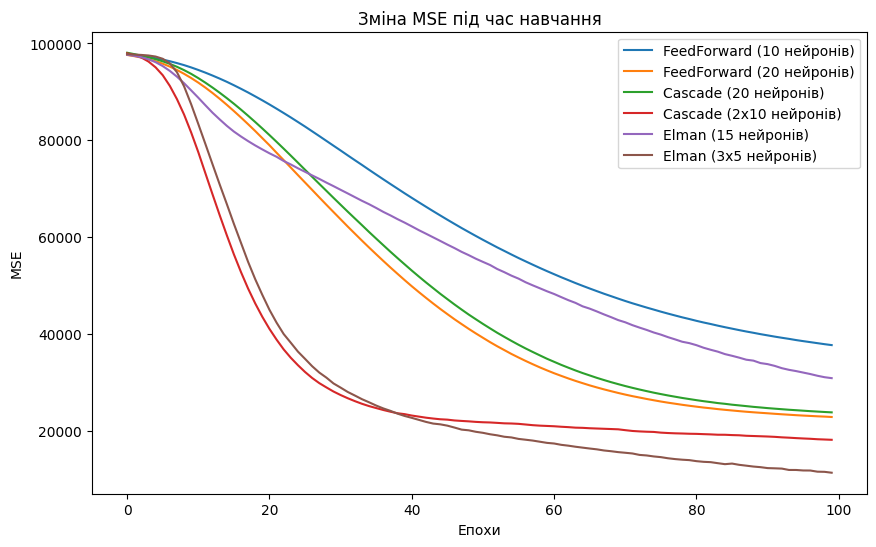

In [5]:
errors = {}
predictions = {}
r2_scores = {}
plt.figure(figsize=(10, 6))
for name, model in models.items():
    print(f"Навчання {name}...")
    if "Elman" in name:
        X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1) )
        X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train_rnn, Y_train, X_test_rnn, Y_test)
    else:
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train, Y_train, X_test, Y_test)
        
    errors[name] = error
    predictions[name] = Y_pred
    r2_scores[name] = r2
    plt.plot(history.history['loss'], label=name)
    
plt.title("Зміна MSE під час навчання")
plt.xlabel("Епохи")
plt.ylabel("MSE")
plt.legend()
plt.show()

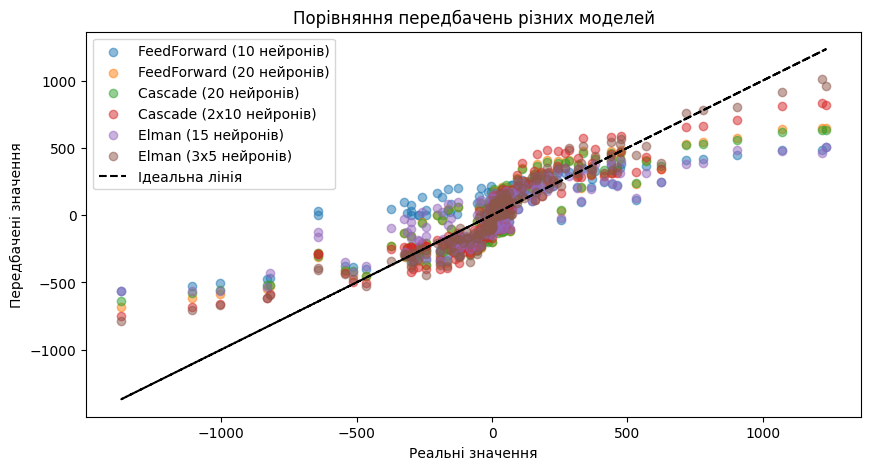

In [6]:
plt.figure(figsize=(10, 5))
for name, Y_pred in predictions.items():
    plt.scatter(Y_test, Y_pred, label=name, alpha=0.5)
plt.plot(Y_test, Y_test, 'k--', label="Ідеальна лінія")
plt.xlabel("Реальні значення")
plt.ylabel("Передбачені значення")
plt.legend()
plt.title("Порівняння передбачень різних моделей")
plt.show()

In [7]:
for name, error in errors.items():
    print(f"{name}: середня відносна помилка = {error:.4f}, R² = {r2_scores[name]:.4f}")

FeedForward (10 нейронів): середня відносна помилка = 296.0408, R² = 0.5814
FeedForward (20 нейронів): середня відносна помилка = 390.6220, R² = 0.7459
Cascade (20 нейронів): середня відносна помилка = 384.2987, R² = 0.7396
Cascade (2x10 нейронів): середня відносна помилка = 415.4073, R² = 0.7996
Elman (15 нейронів): середня відносна помилка = 308.8955, R² = 0.6706
Elman (3x5 нейронів): середня відносна помилка = 385.9801, R² = 0.8843
